In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob
from sklearn.preprocessing import MinMaxScaler

import joblib

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


2022-08-15 17:32:04.144792: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-08-15 17:32:04.377482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:a1:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.77GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-15 17:32:04.378844: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 1 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.77GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-15 17:32:04.415733: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-15 17:32:04.929848: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library l

In [3]:
os.environ['CUDA_VISIBLE_DEVICE'] = "0,1"

In [4]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [5]:
import time

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional,Dense,Flatten,SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

epoch = 150
total_data = [60]
rentang_prediksi = [45,60]
best_LR_BS = [
    (0.001,16),
    (0.0001,16),
]
model_names = ['LSTM','BiLSTM']
# model_names = ['BiLSTM']
# try_BS = [150,100,50,20,10]
# try_LR = [0.1,0.01,0.001,0.0001]
tf.debugging.set_log_device_placement(True)
# gpus = tf.config.list_logical_devices('GPU')
# strategy = tf.distribute.MirroredStrategy(gpus)
for total in total_data:
    for rentang in rentang_prediksi:
        direktori = f'TotalData {total} menit-RentangPrediksi {rentang} menit'
        if (not os.path.exists(direktori)):
            os.mkdir(direktori)
        
        x = joblib.load(f'{direktori}/x_training.data')
        y = joblib.load(f'{direktori}/y_training.data')
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=10)
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 8
        n_steps = X_train.shape[1]
        
        for model_name in model_names:
            catatan_waktu_awal = []
            catatan_waktu_akhir = []

            for lrate,batch in best_LR_BS:
                print(batch,lrate)
                catatan_waktu_awal.append(time.time())
#                 with strategy.scope():
                model = Sequential()
                if model_name == 'LSTM':
                    model.add(LSTM(100, input_shape=(n_steps, n_features), return_sequences=True))
                elif model_name =='BiLSTM':
                    forward_layer = LSTM(100, return_sequences=True)
                    backward_layer = LSTM(100, activation='relu', return_sequences=True,go_backwards=True)
                    model.add(Bidirectional(forward_layer, backward_layer=backward_layer,input_shape=(n_steps,n_features)))
                else:
                    model.add(SimpleRNN(100, input_shape=(n_steps, n_features), return_sequences=True))
                model.add(Flatten())
                model.add(Dense(1))
                optimizer = tf.keras.optimizers.Adam(learning_rate=lrate)
                model.compile(loss="mse", optimizer=optimizer)
                checkpoint_path = f"./{direktori}/{model_name}-epoch{epoch}-BS{batch}-LR{lrate}.h5"
                callbacks = [
                    ModelCheckpoint(checkpoint_path,
                                    monitor='loss', mode="max", verbose=0,
                                    save_weights_only=False, save_freq="epoch")
                ]
                history = model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                                    batch_size = batch,epochs=epoch, verbose=1,callbacks=callbacks)
                model.save(f'{direktori}/{model_name}-epoch{epoch}-BS{batch}-LR{lrate}.h5')
                catatan_waktu_akhir.append(time.time())
                joblib.dump(history.history,f'{direktori}/{model_name}-epoch{epoch}-BS{batch}-LR{lrate}.hist')
            joblib.dump(catatan_waktu_awal,f'{direktori}/waktuAwal-{model_name}-epoch{epoch}-BS{batch}-LR{lrate}.list')
            joblib.dump(catatan_waktu_akhir,f'{direktori}/waktuAkhir-{model_name}-epoch{epoch}-BS{batch}-LR{lrate}.list')

16 0.001
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0


2022-08-11 13:44:41.956015: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-08-11 13:44:41.981470: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3499910000 Hz
2022-08-11 13:44:41.983150: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56215896efa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-11 13:44:41.983194: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-11 13:44:42.229367: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x562158999f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-11 13:44:42.229390: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2022-08-11 1

Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Qr in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DiagPart in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sign in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/dev

2022-08-11 13:44:44.194385: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-11 13:44:44.194411: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-11 13:44:44.194415: I tensorflow/core/common_runtime/placer.cc:54] sequential_lstm_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:44.194419: I tensorflow/core/common_runtime/placer.cc:54] sequential_lstm_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:44.194422: I tensorflow/core/common_runtime/placer.cc:54] sequential_lstm_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:44.194425: I tensorflow/core/common_runtime/placer.cc:54] sequential_dense_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-

2022-08-11 13:44:44.432967: I tensorflow/core/common_runtime/placer.cc:54] inputs: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:44.433024: I tensorflow/core/common_runtime/placer.cc:54] kernel: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:44.433038: I tensorflow/core/common_runtime/placer.cc:54] recurrent_kernel: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:44.433050: I tensorflow/core/common_runtime/placer.cc:54] bias: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:44.433071: I tensorflow/core/common_runtime/placer.cc:54] transpose_0: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:44.433108: I tensorflow/core/common_runtime/placer.cc:54] ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:44.433123: I tensorflow/core/common_runtime/placer.cc:54] ExpandDims_1: (ExpandDims): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-

Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_2/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Const_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_3/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Const_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Cast_2/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Cast_3/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Size: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Shape_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
range/start: (Const): /job:localhost/replica:0/task:0/device:GPU:0
range/delta: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Fill/value: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Maximum/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Maximum/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
floordiv/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Reshape_4/shape: (Const): /job:l

    48/313552 [..............................] - ETA: 3:17:37 - loss: 0.0926

2022-08-11 13:44:45.249885: I tensorflow/core/common_runtime/placer.cc:54] placeholder_1: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:45.249932: I tensorflow/core/common_runtime/placer.cc:54] gradients_strided_slice_grad_stridedslicegrad_strided_slice_stack: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:45.249945: I tensorflow/core/common_runtime/placer.cc:54] gradients_strided_slice_grad_stridedslicegrad_strided_slice_stack_1: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:45.249956: I tensorflow/core/common_runtime/placer.cc:54] gradients_strided_slice_grad_stridedslicegrad_strided_slice_stack_2: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:45.249966: I tensorflow/core/common_runtime/placer.cc:54] gradients_transpose_9_grad_invertpermutation_transpose_9_perm: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:44:45.249976: I tensorflow/core/common_runtime/placer.cc:54] gr

313520/313552 [============================>.] - ETA: 0s - loss: 9.3067e-04Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_42308 in device /job:localhost/replica:0/task:0/device:GPU:0
eeze_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Squeeze_1_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/ExpandDims_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/ExpandDims_1_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Rank: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_2: (Const): /job:localhost/rep

sequential/lstm/zeros/mul/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/lstm/zeros/Less/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/lstm/zeros/packed/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/lstm/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/lstm/zeros_1/mul/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/lstm/zeros_1/Less/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/lstm/zeros_1/packed/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/lstm/zeros_1/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/flatten/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_loss/Mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_loss/weighted_loss/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_loss/weighted_loss/broadcast_weights/assert

2022-08-11 13:47:01.048491: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-11 13:47:01.048519: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-11 13:47:01.048524: I tensorflow/core/common_runtime/placer.cc:54] sequential_lstm_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:47:01.048527: I tensorflow/core/common_runtime/placer.cc:54] sequential_lstm_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:47:01.048530: I tensorflow/core/common_runtime/placer.cc:54] sequential_lstm_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 13:47:01.048533: I tensorflow/core/common_runtime/placer.cc:54] sequential_dense_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
313552/313552 [==============================] - 158s 505us/sample - loss: 9.3073e-04 - val_loss: 8.0899e-04
Epoch 2/150
313504/313552 [============================>.] - ETA: 0s - loss: 8.2783e-04Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
313552/313552 [==============================] - 151s 480us/sample - loss: 8.2777e-04 - val_loss: 7.9256e-04
Epoch 3/150
313552/313552 [==============================] - 150s 479us/sample - loss: 8.1664e-04 - val_loss: 8.6200e-04
Epoch 4/150
313552/313552 [==============================] - 151s 481us/sample - loss: 8.0

Epoch 30/150
313552/313552 [==============================] - 148s 473us/sample - loss: 7.6532e-04 - val_loss: 7.4542e-04
Epoch 31/150
313552/313552 [==============================] - 148s 473us/sample - loss: 7.6476e-04 - val_loss: 7.4811e-04
Epoch 32/150
313552/313552 [==============================] - 149s 474us/sample - loss: 7.6372e-04 - val_loss: 7.5121e-04
Epoch 33/150
313552/313552 [==============================] - 149s 476us/sample - loss: 7.6302e-04 - val_loss: 7.4144e-04
Epoch 34/150
313552/313552 [==============================] - 149s 476us/sample - loss: 7.6242e-04 - val_loss: 7.4799e-04
Epoch 35/150
313552/313552 [==============================] - 150s 478us/sample - loss: 7.6140e-04 - val_loss: 7.5079e-04
Epoch 36/150
313552/313552 [==============================] - 150s 479us/sample - loss: 7.6141e-04 - val_loss: 7.4236e-04
Epoch 37/150
313552/313552 [==============================] - 150s 478us/sample - loss: 7.6041e-04 - val_loss: 7.5244e-04
Epoch 38/150
313552/3135

313552/313552 [==============================] - 150s 479us/sample - loss: 7.4984e-04 - val_loss: 7.4060e-04
Epoch 60/150
313552/313552 [==============================] - 150s 478us/sample - loss: 7.5006e-04 - val_loss: 7.3806e-04
Epoch 61/150
313552/313552 [==============================] - 150s 479us/sample - loss: 7.4832e-04 - val_loss: 7.5320e-04
Epoch 62/150
313552/313552 [==============================] - 150s 479us/sample - loss: 7.4814e-04 - val_loss: 7.4596e-04
Epoch 63/150
313552/313552 [==============================] - 150s 479us/sample - loss: 7.4917e-04 - val_loss: 7.3667e-04
Epoch 64/150
313552/313552 [==============================] - 150s 478us/sample - loss: 7.5228e-04 - val_loss: 7.5367e-04
Epoch 65/150
313552/313552 [==============================] - 150s 479us/sample - loss: 7.4680e-04 - val_loss: 7.6765e-04
Epoch 66/150
313552/313552 [==============================] - 150s 479us/sample - loss: 7.4657e-04 - val_loss: 7.6115e-04
Epoch 67/150
313552/313552 [=========

313552/313552 [==============================] - 151s 483us/sample - loss: 7.3106e-04 - val_loss: 7.2380e-04
Epoch 119/150
313552/313552 [==============================] - 151s 483us/sample - loss: 7.3070e-04 - val_loss: 7.2442e-04
Epoch 120/150
313552/313552 [==============================] - 151s 482us/sample - loss: 7.3077e-04 - val_loss: 7.4020e-04
Epoch 121/150
313552/313552 [==============================] - 151s 482us/sample - loss: 7.2984e-04 - val_loss: 7.3132e-04
Epoch 122/150
313552/313552 [==============================] - 151s 482us/sample - loss: 7.2953e-04 - val_loss: 7.1820e-04
Epoch 123/150
313552/313552 [==============================] - 152s 484us/sample - loss: 7.2907e-04 - val_loss: 7.2472e-04
Epoch 124/150
313552/313552 [==============================] - 151s 483us/sample - loss: 7.2896e-04 - val_loss: 7.5871e-04
Epoch 125/150
313552/313552 [==============================] - 151s 483us/sample - loss: 7.2828e-04 - val_loss: 7.2370e-04
Epoch 126/150
313552/313552 [=

Epoch 148/150
313552/313552 [==============================] - 151s 483us/sample - loss: 7.2236e-04 - val_loss: 7.7555e-04
Epoch 149/150
313552/313552 [==============================] - 151s 483us/sample - loss: 7.2289e-04 - val_loss: 7.3619e-04
Epoch 150/150
313552/313552 [==============================] - 152s 483us/sample - loss: 7.2214e-04 - val_loss: 7.2212e-04
16 0.0001
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost

2022-08-11 20:00:46.219629: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-11 20:00:46.219656: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-11 20:00:46.219661: I tensorflow/core/common_runtime/placer.cc:54] sequential_1_lstm_1_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 20:00:46.219664: I tensorflow/core/common_runtime/placer.cc:54] sequential_1_lstm_1_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 20:00:46.219667: I tensorflow/core/common_runtime/placer.cc:54] sequential_1_lstm_1_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 20:00:46.219670: I tensorflow/core/common_runtime/placer.cc:54] sequential_1_dense_1_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/de

313536/313552 [============================>.] - ETA: 0s - loss: 9.2661e-04Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_7401006 in device /job:localhost/replica:0/task:0/device:GPU:0
ients/concat_1_grad/Shape_4: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_5: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_6: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_7: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_8: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_9: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_10: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_11: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_12: (Const)

2022-08-11 20:02:57.704759: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-11 20:02:57.704785: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-11 20:02:57.704790: I tensorflow/core/common_runtime/placer.cc:54] sequential_1_lstm_1_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 20:02:57.704793: I tensorflow/core/common_runtime/placer.cc:54] sequential_1_lstm_1_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 20:02:57.704796: I tensorflow/core/common_runtime/placer.cc:54] sequential_1_lstm_1_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-11 20:02:57.704800: I tensorflow/core/common_runtime/placer.cc:54] sequential_1_dense_1_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/de

313552/313552 [==============================] - 153s 487us/sample - loss: 9.2668e-04 - val_loss: 7.8470e-04
Epoch 2/150
313552/313552 [==============================] - 152s 484us/sample - loss: 8.2498e-04 - val_loss: 7.7863e-04
Epoch 3/150
313552/313552 [==============================] - 152s 484us/sample - loss: 8.1048e-04 - val_loss: 7.6653e-04
Epoch 4/150
313552/313552 [==============================] - 152s 485us/sample - loss: 8.0387e-04 - val_loss: 7.7125e-04
Epoch 5/150
313552/313552 [==============================] - 152s 484us/sample - loss: 7.9798e-04 - val_loss: 7.7989e-04
Epoch 6/150
313552/313552 [==============================] - 151s 483us/sample - loss: 7.9565e-04 - val_loss: 7.6314e-04
Epoch 7/150
313552/313552 [==============================] - 152s 483us/sample - loss: 7.9182e-04 - val_loss: 7.6850e-04
Epoch 8/150
313552/313552 [==============================] - 152s 483us/sample - loss: 7.8894e-04 - val_loss: 7.6099e-04
Epoch 9/150
313552/313552 [=================

313552/313552 [==============================] - 151s 482us/sample - loss: 7.4060e-04 - val_loss: 7.3448e-04
Epoch 61/150
313552/313552 [==============================] - 152s 484us/sample - loss: 7.3891e-04 - val_loss: 7.2929e-04
Epoch 62/150
313552/313552 [==============================] - 152s 483us/sample - loss: 7.3974e-04 - val_loss: 7.4290e-04
Epoch 63/150
313552/313552 [==============================] - 152s 484us/sample - loss: 7.3879e-04 - val_loss: 7.2396e-04
Epoch 64/150
313552/313552 [==============================] - 152s 484us/sample - loss: 7.3851e-04 - val_loss: 7.3894e-04
Epoch 65/150
313552/313552 [==============================] - 152s 484us/sample - loss: 7.3792e-04 - val_loss: 7.5331e-04
Epoch 66/150
313552/313552 [==============================] - 152s 484us/sample - loss: 7.3790e-04 - val_loss: 7.4311e-04
Epoch 67/150
313552/313552 [==============================] - 151s 483us/sample - loss: 7.3631e-04 - val_loss: 7.3014e-04
Epoch 68/150
313552/313552 [=========

313552/313552 [==============================] - 160s 510us/sample - loss: 7.0329e-04 - val_loss: 6.9429e-04
Epoch 120/150
313552/313552 [==============================] - 159s 509us/sample - loss: 7.0100e-04 - val_loss: 7.0492e-04
Epoch 121/150
313552/313552 [==============================] - 160s 510us/sample - loss: 7.0025e-04 - val_loss: 7.0890e-04
Epoch 122/150
313552/313552 [==============================] - 160s 510us/sample - loss: 7.0044e-04 - val_loss: 6.9843e-04
Epoch 123/150
313552/313552 [==============================] - 160s 509us/sample - loss: 6.9946e-04 - val_loss: 6.9592e-04
Epoch 124/150
313552/313552 [==============================] - 160s 509us/sample - loss: 6.9985e-04 - val_loss: 6.9446e-04
Epoch 125/150
313552/313552 [==============================] - 160s 509us/sample - loss: 6.9960e-04 - val_loss: 6.9662e-04
Epoch 126/150
313552/313552 [==============================] - 160s 510us/sample - loss: 6.9896e-04 - val_loss: 6.9475e-04
Epoch 127/150
313552/313552 [=

Epoch 149/150
313552/313552 [==============================] - 160s 510us/sample - loss: 6.8600e-04 - val_loss: 6.8685e-04
Epoch 150/150
313552/313552 [==============================] - 160s 509us/sample - loss: 6.8548e-04 - val_loss: 6.8493e-04
16 0.001
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

2022-08-12 02:24:31.224630: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-12 02:24:31.224659: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-12 02:24:31.224664: I tensorflow/core/common_runtime/placer.cc:54] sequential_2_bidirectional_forward_lstm_2_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:24:31.224668: I tensorflow/core/common_runtime/placer.cc:54] sequential_2_bidirectional_forward_lstm_2_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:24:31.224671: I tensorflow/core/common_runtime/placer.cc:54] sequential_2_bidirectional_forward_lstm_2_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:24:31.224674: I tensorflow/core/common_runtime/placer.cc:54] sequential_2_bidirectional_ba

/backward_lstm_3/while_grad/body/_105/gradients/mul_2_grad/Mul_1/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_2/bidirectional/backward_lstm_3/while_grad/body/_105/gradients/mul_grad/Mul/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_2/bidirectional/backward_lstm_3/while_grad/body/_105/gradients/mul_grad/Mul_1/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_2/bidirectional/backward_lstm_3/while_grad/body/_105/gradients/mul_1_grad/Mul/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_2/bidirectional/backward_lstm_3/while_grad/body/_105/gradients/mul_1_grad/Mul_1/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_2/bidirectional/backward_lstm_3/while_grad/body/_105/gradients/split_grad/concat/Const: (Const): /job:localhost/replica:0/task:0/devi

2022-08-12 02:24:31.596301: I tensorflow/core/common_runtime/placer.cc:54] inputs: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:24:31.596358: I tensorflow/core/common_runtime/placer.cc:54] kernel: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:24:31.596373: I tensorflow/core/common_runtime/placer.cc:54] recurrent_kernel: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:24:31.596385: I tensorflow/core/common_runtime/placer.cc:54] bias: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:24:31.596405: I tensorflow/core/common_runtime/placer.cc:54] transpose_0: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:24:31.596420: I tensorflow/core/common_runtime/placer.cc:54] ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:24:31.596434: I tensorflow/core/common_runtime/placer.cc:54] ExpandDims_1: (ExpandDims): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-

313536/313552 [============================>.] - ETA: 0s - loss: 9.7254e-04Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_14760993 in device /job:localhost/replica:0/task:0/device:GPU:0
U:0
gradients/concat_1_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_4: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_5: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_6: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_7: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_8: (Co

sequential_2/bidirectional/backward_lstm_3/runtime: (Const): /job:localhost/replica:0/task:0/device:CPU:0
sequential_2/bidirectional/ReverseV2/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_2/bidirectional/concat/axis: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_2/flatten_2/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_2_loss/Mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_2_loss/weighted_loss/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_2_loss/weighted_loss/broadcast_weights/assert_broadcastable/weights/shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_2_loss/weighted_loss/broadcast_weights/assert_broadcastable/weights/rank: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_2_loss/weighted_loss/broadcast_weights/assert_broadcastable/values/rank: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_2

2022-08-12 02:36:55.830687: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-12 02:36:55.830711: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-12 02:36:55.830716: I tensorflow/core/common_runtime/placer.cc:54] sequential_2_bidirectional_forward_lstm_2_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:36:55.830720: I tensorflow/core/common_runtime/placer.cc:54] sequential_2_bidirectional_forward_lstm_2_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:36:55.830723: I tensorflow/core/common_runtime/placer.cc:54] sequential_2_bidirectional_forward_lstm_2_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-12 02:36:55.830726: I tensorflow/core/common_runtime/placer.cc:54] sequential_2_bidirectional_ba

313552/313552 [==============================] - 818s 3ms/sample - loss: 9.7253e-04 - val_loss: 9.5364e-04
Epoch 2/150
313552/313552 [==============================] - 816s 3ms/sample - loss: 8.3065e-04 - val_loss: 7.7108e-04
Epoch 3/150
313552/313552 [==============================] - 818s 3ms/sample - loss: 8.1498e-04 - val_loss: 7.7420e-04
Epoch 4/150
313552/313552 [==============================] - 817s 3ms/sample - loss: 8.0741e-04 - val_loss: 7.7176e-04
Epoch 5/150
313552/313552 [==============================] - 819s 3ms/sample - loss: 8.0241e-04 - val_loss: 8.3544e-04
Epoch 6/150
313552/313552 [==============================] - 819s 3ms/sample - loss: 7.9938e-04 - val_loss: 7.6671e-04
Epoch 7/150
313552/313552 [==============================] - 818s 3ms/sample - loss: 7.9571e-04 - val_loss: 7.6446e-04
Epoch 8/150
313552/313552 [==============================] - 817s 3ms/sample - loss: 7.9304e-04 - val_loss: 7.6927e-04
Epoch 9/150
313552/313552 [==============================] -

Epoch 61/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 7.4703e-04 - val_loss: 7.3008e-04
Epoch 62/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 7.4599e-04 - val_loss: 7.4522e-04
Epoch 63/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 7.5607e-04 - val_loss: 7.3459e-04
Epoch 64/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.4537e-04 - val_loss: 8.9254e-04
Epoch 65/150
313552/313552 [==============================] - 841s 3ms/sample - loss: 0.0724 - val_loss: 0.0380
Epoch 66/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 0.0137 - val_loss: 0.0039
Epoch 67/150
313552/313552 [==============================] - 836s 3ms/sample - loss: 0.0024 - val_loss: 0.0016
Epoch 68/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 0.0015 - val_loss: 0.0019
Epoch 69/150
313552/313552 [==============================] - 838s 3ms/s

Epoch 91/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.4926e-04 - val_loss: 7.3254e-04
Epoch 92/150
313552/313552 [==============================] - 837s 3ms/sample - loss: 7.4787e-04 - val_loss: 7.3583e-04
Epoch 93/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 7.4672e-04 - val_loss: 7.3375e-04
Epoch 94/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.4573e-04 - val_loss: 8.0864e-04
Epoch 95/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 7.4599e-04 - val_loss: 7.9925e-04
Epoch 96/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.5030e-04 - val_loss: 7.4657e-04
Epoch 97/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 7.4411e-04 - val_loss: 7.3079e-04
Epoch 98/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.4466e-04 - val_loss: 7.3194e-04
Epoch 99/150
313552/313552 [============

313552/313552 [==============================] - 839s 3ms/sample - loss: 7.3520e-04 - val_loss: 7.3652e-04
Epoch 121/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 8.6513e-04 - val_loss: 7.5108e-04
Epoch 122/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.3862e-04 - val_loss: 7.2429e-04
Epoch 123/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 0.0031 - val_loss: 0.0028
Epoch 124/150
313552/313552 [==============================] - 836s 3ms/sample - loss: 0.0014 - val_loss: 9.2856e-04
Epoch 125/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.7484e-04 - val_loss: 7.3526e-04
Epoch 126/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.3906e-04 - val_loss: 7.2542e-04
Epoch 127/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.4647e-04 - val_loss: 7.5122e-04
Epoch 128/150
313552/313552 [=============================

2022-08-13 13:02:15.388610: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-13 13:02:15.388639: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-13 13:02:15.388644: I tensorflow/core/common_runtime/placer.cc:54] sequential_3_bidirectional_1_forward_lstm_4_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:02:15.388648: I tensorflow/core/common_runtime/placer.cc:54] sequential_3_bidirectional_1_forward_lstm_4_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:02:15.388651: I tensorflow/core/common_runtime/placer.cc:54] sequential_3_bidirectional_1_forward_lstm_4_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:02:15.388654: I tensorflow/core/common_runtime/placer.cc:54] sequential_3_bidirectio

t_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Adam/add/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Adam/sub/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Adam/sub_1/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Adam/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Adam/sub_2/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Adam/sub_3/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Adam/Adam/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while/body/_1/TensorArrayV2Read/TensorListGetItem/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while/body/_1/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while/body/_1/split/split_dim: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while

    48/313552 [..............................] - ETA: 2:15:48 - loss: 0.1602

2022-08-13 13:02:15.717136: I tensorflow/core/common_runtime/placer.cc:54] inputs: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:02:15.717181: I tensorflow/core/common_runtime/placer.cc:54] kernel: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:02:15.717195: I tensorflow/core/common_runtime/placer.cc:54] recurrent_kernel: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:02:15.717207: I tensorflow/core/common_runtime/placer.cc:54] bias: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:02:15.717228: I tensorflow/core/common_runtime/placer.cc:54] transpose_0: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:02:15.717242: I tensorflow/core/common_runtime/placer.cc:54] ExpandDims: (ExpandDims): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:02:15.717256: I tensorflow/core/common_runtime/placer.cc:54] ExpandDims_1: (ExpandDims): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-

313536/313552 [============================>.] - ETA: 0s - loss: 9.2042e-04Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_22123698 in device /job:localhost/replica:0/task:0/device:GPU:0
replica:0/task:0/device:GPU:0
gradients/Reshape_6_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Reshape_7_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Reshape_8_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Reshape_9_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Reshape_10_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Reshape_11_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Reshape_12_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Reshape_13_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Re

sequential_3/bidirectional_1/backward_lstm_5/while/exit/_34: (Exit): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while/exit/_35: (Exit): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while/exit/_36: (Exit): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while/exit/_37: (Exit): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while/exit/_38: (Exit): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while/exit/_39: (Exit): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while/LoopExecuted/_40: (NoOp): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while: (NoOp): /job:localhost/replica:0/task:0/device:GPU:0
sequential_3/bidirectional_1/backward_lstm_5/while/next_iteration/_41: (NextIteration): /

2022-08-13 13:14:58.448048: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-13 13:14:58.448076: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-13 13:14:58.448081: I tensorflow/core/common_runtime/placer.cc:54] sequential_3_bidirectional_1_forward_lstm_4_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:14:58.448085: I tensorflow/core/common_runtime/placer.cc:54] sequential_3_bidirectional_1_forward_lstm_4_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:14:58.448088: I tensorflow/core/common_runtime/placer.cc:54] sequential_3_bidirectional_1_forward_lstm_4_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-13 13:14:58.448092: I tensorflow/core/common_runtime/placer.cc:54] sequential_3_bidirectio

313552/313552 [==============================] - 839s 3ms/sample - loss: 9.2042e-04 - val_loss: 7.6834e-04
Epoch 2/150
313552/313552 [==============================] - 840s 3ms/sample - loss: 8.0130e-04 - val_loss: 7.8694e-04
Epoch 3/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.8393e-04 - val_loss: 9.3942e-04
Epoch 4/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 7.7072e-04 - val_loss: 7.5960e-04
Epoch 5/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 7.6143e-04 - val_loss: 7.4007e-04
Epoch 6/150
313552/313552 [==============================] - 837s 3ms/sample - loss: 7.5205e-04 - val_loss: 7.2601e-04
Epoch 7/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 7.4734e-04 - val_loss: 7.3227e-04
Epoch 8/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 7.3843e-04 - val_loss: 7.3508e-04
Epoch 9/150
313552/313552 [==============================] -

Epoch 61/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 5.6325e-04 - val_loss: 5.7394e-04
Epoch 62/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 5.5670e-04 - val_loss: 5.3810e-04
Epoch 63/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 5.5664e-04 - val_loss: 5.6811e-04
Epoch 64/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 5.5694e-04 - val_loss: 5.5550e-04
Epoch 65/150
313552/313552 [==============================] - 837s 3ms/sample - loss: 5.5206e-04 - val_loss: 5.5883e-04
Epoch 66/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 5.5921e-04 - val_loss: 5.6487e-04
Epoch 67/150
313552/313552 [==============================] - 839s 3ms/sample - loss: 5.5251e-04 - val_loss: 5.4636e-04
Epoch 68/150
313552/313552 [==============================] - 838s 3ms/sample - loss: 5.5207e-04 - val_loss: 5.6559e-04
Epoch 69/150
313552/313552 [============

Epoch 91/150
313552/313552 [==============================] - 867s 3ms/sample - loss: 5.2353e-04 - val_loss: 5.5701e-04
Epoch 92/150
313552/313552 [==============================] - 858s 3ms/sample - loss: 5.2203e-04 - val_loss: 5.5374e-04
Epoch 93/150
313552/313552 [==============================] - 847s 3ms/sample - loss: 5.2329e-04 - val_loss: 5.1175e-04
Epoch 94/150
313552/313552 [==============================] - 813s 3ms/sample - loss: 5.1678e-04 - val_loss: 5.2954e-04
Epoch 95/150
313552/313552 [==============================] - 821s 3ms/sample - loss: 5.2031e-04 - val_loss: 5.3521e-04
Epoch 96/150
313552/313552 [==============================] - 848s 3ms/sample - loss: 5.1583e-04 - val_loss: 5.1460e-04
Epoch 97/150
313552/313552 [==============================] - 846s 3ms/sample - loss: 5.1746e-04 - val_loss: 5.2689e-04
Epoch 98/150
313552/313552 [==============================] - 824s 3ms/sample - loss: 5.1631e-04 - val_loss: 5.2219e-04
Epoch 99/150
313552/313552 [============

313552/313552 [==============================] - 821s 3ms/sample - loss: 5.0121e-04 - val_loss: 5.5481e-04
Epoch 121/150
313552/313552 [==============================] - 821s 3ms/sample - loss: 4.9841e-04 - val_loss: 4.9740e-04
Epoch 122/150
313552/313552 [==============================] - 821s 3ms/sample - loss: 4.9729e-04 - val_loss: 5.0932e-04
Epoch 123/150
313552/313552 [==============================] - 822s 3ms/sample - loss: 4.9647e-04 - val_loss: 5.0631e-04
Epoch 124/150
313552/313552 [==============================] - 823s 3ms/sample - loss: 4.9474e-04 - val_loss: 5.2329e-04
Epoch 125/150
313552/313552 [==============================] - 823s 3ms/sample - loss: 4.9756e-04 - val_loss: 4.9503e-04
Epoch 126/150
313552/313552 [==============================] - 823s 3ms/sample - loss: 4.9623e-04 - val_loss: 5.2210e-04
Epoch 127/150
313552/313552 [==============================] - 822s 3ms/sample - loss: 4.9452e-04 - val_loss: 4.8557e-04
Epoch 128/150
313552/313552 [=================

2022-08-14 23:44:03.079316: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-14 23:44:03.079345: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-14 23:44:03.079350: I tensorflow/core/common_runtime/placer.cc:54] sequential_4_lstm_6_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-14 23:44:03.079353: I tensorflow/core/common_runtime/placer.cc:54] sequential_4_lstm_6_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-14 23:44:03.079356: I tensorflow/core/common_runtime/placer.cc:54] sequential_4_lstm_6_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-14 23:44:03.079360: I tensorflow/core/common_runtime/placer.cc:54] sequential_4_dense_4_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/de

311808/311836 [============================>.] - ETA: 0s - loss: 0.0010Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_29485153 in device /job:localhost/replica:0/task:0/device:GPU:0
a:0/task:0/device:GPU:0
identity_4_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
identity_5_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
placeholder_4: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Rank: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_4: (Const): /job:localhost/replica:

sequential_4/lstm_6/zeros/mul/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_4/lstm_6/zeros/Less/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_4/lstm_6/zeros/packed/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_4/lstm_6/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_4/lstm_6/zeros_1/mul/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_4/lstm_6/zeros_1/Less/y: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_4/lstm_6/zeros_1/packed/1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_4/lstm_6/zeros_1/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_4/flatten_4/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_4_loss/Mean/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_4_loss/weighted_loss/Cast/x: (Const): /job:localhost/replica:0/task:0/device:GPU:0
loss/dense_4_l

2022-08-14 23:46:22.753807: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-14 23:46:22.753833: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-14 23:46:22.753838: I tensorflow/core/common_runtime/placer.cc:54] sequential_4_lstm_6_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-14 23:46:22.753842: I tensorflow/core/common_runtime/placer.cc:54] sequential_4_lstm_6_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-14 23:46:22.753845: I tensorflow/core/common_runtime/placer.cc:54] sequential_4_lstm_6_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-14 23:46:22.753848: I tensorflow/core/common_runtime/placer.cc:54] sequential_4_dense_4_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/de

311836/311836 [==============================] - 161s 515us/sample - loss: 0.0010 - val_loss: 9.9016e-04
Epoch 2/150
311836/311836 [==============================] - 160s 513us/sample - loss: 9.4316e-04 - val_loss: 8.8585e-04
Epoch 3/150
311836/311836 [==============================] - 159s 510us/sample - loss: 9.2659e-04 - val_loss: 9.5545e-04
Epoch 4/150
311836/311836 [==============================] - 159s 510us/sample - loss: 9.1894e-04 - val_loss: 9.0426e-04
Epoch 5/150
311836/311836 [==============================] - 159s 511us/sample - loss: 9.1292e-04 - val_loss: 8.8316e-04
Epoch 6/150
311836/311836 [==============================] - 158s 508us/sample - loss: 9.0867e-04 - val_loss: 8.7483e-04
Epoch 7/150
311836/311836 [==============================] - 159s 510us/sample - loss: 9.0585e-04 - val_loss: 8.8936e-04
Epoch 8/150
311836/311836 [==============================] - 158s 507us/sample - loss: 9.0262e-04 - val_loss: 8.7608e-04
Epoch 9/150
311836/311836 [=====================

311836/311836 [==============================] - 157s 503us/sample - loss: 8.4834e-04 - val_loss: 8.2684e-04
Epoch 61/150
311836/311836 [==============================] - 159s 510us/sample - loss: 8.4730e-04 - val_loss: 8.3069e-04
Epoch 62/150
311836/311836 [==============================] - 159s 511us/sample - loss: 8.4676e-04 - val_loss: 8.4212e-04
Epoch 63/150
311836/311836 [==============================] - 158s 506us/sample - loss: 8.4719e-04 - val_loss: 8.2947e-04
Epoch 64/150
311836/311836 [==============================] - 159s 509us/sample - loss: 8.4652e-04 - val_loss: 8.2212e-04
Epoch 65/150
311836/311836 [==============================] - 159s 508us/sample - loss: 8.4626e-04 - val_loss: 8.2991e-04
Epoch 66/150
311836/311836 [==============================] - 159s 510us/sample - loss: 8.7039e-04 - val_loss: 8.5542e-04
Epoch 67/150
311836/311836 [==============================] - 158s 508us/sample - loss: 8.4503e-04 - val_loss: 8.5084e-04
Epoch 68/150
311836/311836 [=========

311836/311836 [==============================] - 159s 509us/sample - loss: 8.7122e-04 - val_loss: 8.8660e-04
Epoch 121/150
311836/311836 [==============================] - 159s 510us/sample - loss: 8.6631e-04 - val_loss: 8.4766e-04
Epoch 122/150
311836/311836 [==============================] - 160s 512us/sample - loss: 8.4668e-04 - val_loss: 8.3461e-04
Epoch 123/150
311836/311836 [==============================] - 159s 509us/sample - loss: 0.0021 - val_loss: 8.3539e-04
Epoch 124/150
311836/311836 [==============================] - 158s 508us/sample - loss: 8.4886e-04 - val_loss: 8.2330e-04
Epoch 125/150
311836/311836 [==============================] - 159s 510us/sample - loss: 8.6163e-04 - val_loss: 8.3516e-04
Epoch 126/150
311836/311836 [==============================] - 158s 505us/sample - loss: 8.4264e-04 - val_loss: 8.3381e-04
Epoch 127/150
311836/311836 [==============================] - 159s 509us/sample - loss: 8.4098e-04 - val_loss: 8.4239e-04
Epoch 128/150
311836/311836 [=====

311836/311836 [==============================] - 158s 506us/sample - loss: 8.2932e-04 - val_loss: 8.2984e-04
Epoch 150/150
311836/311836 [==============================] - 159s 510us/sample - loss: 8.2925e-04 - val_loss: 8.1910e-04
16 0.0001
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RangeD

    16/311836 [..............................] - ETA: 4:16:14 - loss: 0.0483

2022-08-15 06:20:10.062600: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 06:20:10.062643: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 06:20:10.062654: I tensorflow/core/common_runtime/placer.cc:54] sequential_5_lstm_7_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 06:20:10.062661: I tensorflow/core/common_runtime/placer.cc:54] sequential_5_lstm_7_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 06:20:10.062669: I tensorflow/core/common_runtime/placer.cc:54] sequential_5_lstm_7_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 06:20:10.062676: I tensorflow/core/common_runtime/placer.cc:54] sequential_5_dense_5_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/de

311712/311836 [============================>.] - ETA: 0s - loss: 0.0010Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_36803904 in device /job:localhost/replica:0/task:0/device:GPU:0
/device:GPU:0
gradients/Reshape_14_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/Reshape_15_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_grad/Rank: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
sequential_5_lstm_7_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
sequential_5_lstm_7_statefulpartitionedcall_args_4: (_A

2022-08-15 06:22:30.231565: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 06:22:30.231592: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 06:22:30.231596: I tensorflow/core/common_runtime/placer.cc:54] sequential_5_lstm_7_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 06:22:30.231600: I tensorflow/core/common_runtime/placer.cc:54] sequential_5_lstm_7_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 06:22:30.231603: I tensorflow/core/common_runtime/placer.cc:54] sequential_5_lstm_7_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 06:22:30.231607: I tensorflow/core/common_runtime/placer.cc:54] sequential_5_dense_5_matmul_readvariableop_resource: (_Arg): /job:localhost/replica:0/task:0/de

311836/311836 [==============================] - 161s 516us/sample - loss: 0.0010 - val_loss: 8.9401e-04
Epoch 2/150
311836/311836 [==============================] - 160s 513us/sample - loss: 9.2951e-04 - val_loss: 8.8416e-04
Epoch 3/150
311836/311836 [==============================] - 159s 511us/sample - loss: 9.1751e-04 - val_loss: 8.8353e-04
Epoch 4/150
311836/311836 [==============================] - 158s 508us/sample - loss: 9.1057e-04 - val_loss: 9.0539e-04
Epoch 5/150
311836/311836 [==============================] - 159s 511us/sample - loss: 9.0750e-04 - val_loss: 8.8376e-04
Epoch 6/150
311836/311836 [==============================] - 159s 508us/sample - loss: 9.0379e-04 - val_loss: 8.8861e-04
Epoch 7/150
311836/311836 [==============================] - 159s 511us/sample - loss: 9.0114e-04 - val_loss: 8.7698e-04
Epoch 8/150
311836/311836 [==============================] - 160s 513us/sample - loss: 8.9847e-04 - val_loss: 8.7638e-04
Epoch 9/150
311836/311836 [=====================

311836/311836 [==============================] - 158s 506us/sample - loss: 8.4298e-04 - val_loss: 8.3293e-04
Epoch 61/150
311836/311836 [==============================] - 158s 507us/sample - loss: 8.5730e-04 - val_loss: 8.3402e-04
Epoch 62/150
311836/311836 [==============================] - 159s 511us/sample - loss: 8.5059e-04 - val_loss: 8.7097e-04
Epoch 63/150
311836/311836 [==============================] - 158s 508us/sample - loss: 8.4282e-04 - val_loss: 8.2573e-04
Epoch 64/150
311836/311836 [==============================] - 159s 511us/sample - loss: 8.4456e-04 - val_loss: 8.6608e-04
Epoch 65/150
311836/311836 [==============================] - 160s 512us/sample - loss: 8.4143e-04 - val_loss: 8.2446e-04
Epoch 66/150
311836/311836 [==============================] - 159s 509us/sample - loss: 8.4278e-04 - val_loss: 8.6705e-04
Epoch 67/150
311836/311836 [==============================] - 159s 509us/sample - loss: 8.4240e-04 - val_loss: 8.2981e-04
Epoch 68/150
311836/311836 [=========

311836/311836 [==============================] - 162s 519us/sample - loss: 8.1408e-04 - val_loss: 8.0388e-04
Epoch 120/150
311836/311836 [==============================] - 163s 522us/sample - loss: 8.1119e-04 - val_loss: 8.0375e-04
Epoch 121/150
311836/311836 [==============================] - 162s 521us/sample - loss: 8.1388e-04 - val_loss: 8.0459e-04
Epoch 122/150
311836/311836 [==============================] - 163s 522us/sample - loss: 8.1317e-04 - val_loss: 8.0846e-04
Epoch 123/150
311836/311836 [==============================] - 163s 521us/sample - loss: 8.1175e-04 - val_loss: 8.1071e-04
Epoch 124/150
311836/311836 [==============================] - 162s 520us/sample - loss: 8.0931e-04 - val_loss: 7.9650e-04
Epoch 125/150
311836/311836 [==============================] - 163s 522us/sample - loss: 8.0844e-04 - val_loss: 7.9015e-04
Epoch 126/150
311836/311836 [==============================] - 163s 522us/sample - loss: 8.0665e-04 - val_loss: 7.9950e-04
Epoch 127/150
311836/311836 [=

Epoch 149/150
311836/311836 [==============================] - 168s 537us/sample - loss: 7.9243e-04 - val_loss: 7.9203e-04
Epoch 150/150
311836/311836 [==============================] - 168s 537us/sample - loss: 7.9089e-04 - val_loss: 7.8490e-04
16 0.001
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Execut

2022-08-15 13:04:54.895495: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 13:04:54.895524: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 13:04:54.895529: I tensorflow/core/common_runtime/placer.cc:54] sequential_6_bidirectional_2_forward_lstm_8_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:04:54.895533: I tensorflow/core/common_runtime/placer.cc:54] sequential_6_bidirectional_2_forward_lstm_8_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:04:54.895536: I tensorflow/core/common_runtime/placer.cc:54] sequential_6_bidirectional_2_forward_lstm_8_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:04:54.895539: I tensorflow/core/common_runtime/placer.cc:54] sequential_6_bidirectio

quential_6/bidirectional_2/backward_lstm_9/while_grad/body/_130/gradients/add_grad/Shape/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_6/bidirectional_2/backward_lstm_9/while_grad/body/_130/gradients/add_grad/Shape_1/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_6/bidirectional_2/backward_lstm_9/while_grad/body/_130/gradients/MatMul_grad/MatMul/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_6/bidirectional_2/backward_lstm_9/while_grad/body/_130/gradients/MatMul_grad/MatMul_1/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_6/bidirectional_2/backward_lstm_9/while_grad/body/_130/gradients/MatMul_1_grad/MatMul/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential_6/bidirectional_2/backward_lstm_9/while_grad/body/_130/gradients/MatMul_1_grad/MatM

    48/311836 [..............................] - ETA: 2:31:54 - loss: 0.1621

2022-08-15 13:04:55.257748: I tensorflow/core/common_runtime/placer.cc:54] inputs: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:04:55.257780: I tensorflow/core/common_runtime/placer.cc:54] init_h_0: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:04:55.257784: I tensorflow/core/common_runtime/placer.cc:54] init_c_0: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:04:55.257788: I tensorflow/core/common_runtime/placer.cc:54] kernel: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:04:55.257792: I tensorflow/core/common_runtime/placer.cc:54] recurrent_kernel: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:04:55.257795: I tensorflow/core/common_runtime/placer.cc:54] bias: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:04:55.257803: I tensorflow/core/common_runtime/placer.cc:54] transpose_0: (Transpose): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:04:55.257808

311808/311836 [============================>.] - ETA: 0s - loss: 0.0011Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_44124144 in device /job:localhost/replica:0/task:0/device:GPU:0
Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_3: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_4: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_5: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_6: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_7: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_8: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_9: (Const): /job:localhost/replica:0/task:0/de

2022-08-15 13:21:39.786041: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 13:21:39.786068: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 13:21:39.786073: I tensorflow/core/common_runtime/placer.cc:54] sequential_6_bidirectional_2_forward_lstm_8_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:21:39.786076: I tensorflow/core/common_runtime/placer.cc:54] sequential_6_bidirectional_2_forward_lstm_8_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:21:39.786080: I tensorflow/core/common_runtime/placer.cc:54] sequential_6_bidirectional_2_forward_lstm_8_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 13:21:39.786083: I tensorflow/core/common_runtime/placer.cc:54] sequential_6_bidirectio

311836/311836 [==============================] - 1084s 3ms/sample - loss: 0.0011 - val_loss: 8.8563e-04
Epoch 2/150
311836/311836 [==============================] - 1085s 3ms/sample - loss: 9.4622e-04 - val_loss: 8.8192e-04
Epoch 3/150
311836/311836 [==============================] - 1082s 3ms/sample - loss: 9.2774e-04 - val_loss: 8.8256e-04
Epoch 4/150
311836/311836 [==============================] - 1083s 3ms/sample - loss: 9.1782e-04 - val_loss: 0.0010
Epoch 5/150
311836/311836 [==============================] - 1083s 3ms/sample - loss: 9.0957e-04 - val_loss: 8.9371e-04
Epoch 6/150
311836/311836 [==============================] - 1084s 3ms/sample - loss: 9.0400e-04 - val_loss: 8.6986e-04
Epoch 7/150
311836/311836 [==============================] - 1104s 4ms/sample - loss: 9.0022e-04 - val_loss: 8.6832e-04
Epoch 8/150
311836/311836 [==============================] - 1075s 3ms/sample - loss: 8.9656e-04 - val_loss: 8.8400e-04
Epoch 9/150
 19760/311836 [>.............................] -

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional,Dense,Flatten,SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

epoch = 150
total_data = [60]
rentang_prediksi = [60]
best_LR_BS = [
    (0.001,16),
    (0.0001,16),
]
model_names = ['BiLSTM']
# model_names = ['BiLSTM']
# try_BS = [150,100,50,20,10]
# try_LR = [0.1,0.01,0.001,0.0001]
# tf.debugging.set_log_device_placement(True)
# gpus = tf.config.list_logical_devices('GPU')
# strategy = tf.distribute.MirroredStrategy(gpus)
for total in total_data:
    for rentang in rentang_prediksi:
        direktori = f'TotalData {total} menit-RentangPrediksi {rentang} menit'
        if (not os.path.exists(direktori)):
            os.mkdir(direktori)
        
        x = joblib.load(f'{direktori}/x_training.data')
        y = joblib.load(f'{direktori}/y_training.data')
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=10)
        # reshape from [samples, timesteps] into [samples, timesteps, features]
        n_features = 8
        n_steps = X_train.shape[1]
        
        for model_name in model_names:
            catatan_waktu_awal = []
            catatan_waktu_akhir = []

            for lrate,batch in best_LR_BS:
                print(batch,lrate)
                catatan_waktu_awal.append(time.time())
#                 with strategy.scope():
                model = Sequential()
                if model_name == 'LSTM':
                    model.add(LSTM(100, input_shape=(n_steps, n_features), return_sequences=True))
                elif model_name =='BiLSTM':
                    forward_layer = LSTM(100, return_sequences=True)
                    backward_layer = LSTM(100, activation='relu', return_sequences=True,go_backwards=True)
                    model.add(Bidirectional(forward_layer, backward_layer=backward_layer,input_shape=(n_steps,n_features)))
                else:
                    model.add(SimpleRNN(100, input_shape=(n_steps, n_features), return_sequences=True))
                model.add(Flatten())
                model.add(Dense(1))
                optimizer = tf.keras.optimizers.Adam(learning_rate=lrate)
                model.compile(loss="mse", optimizer=optimizer)
                checkpoint_path = f"./{direktori}/{model_name}-epoch{epoch}-BS{batch}-LR{lrate}.h5"
                callbacks = [
                    ModelCheckpoint(checkpoint_path,
                                    monitor='loss', mode="max", verbose=0,
                                    save_weights_only=False, save_freq="epoch")
                ]
                history = model.fit(X_train, y_train,validation_data=(X_test,y_test), 
                                    batch_size = batch,epochs=epoch, verbose=1,callbacks=callbacks)
                model.save(f'{direktori}/{model_name}-epoch{epoch}-BS{batch}-LR{lrate}.h5')
                catatan_waktu_akhir.append(time.time())
                joblib.dump(history.history,f'{direktori}/{model_name}-epoch{epoch}-BS{batch}-LR{lrate}.hist')
            joblib.dump(catatan_waktu_awal,f'{direktori}/waktuAwal-{model_name}-epoch{epoch}-BS{batch}-LR{lrate}.list')
            joblib.dump(catatan_waktu_akhir,f'{direktori}/waktuAkhir-{model_name}-epoch{epoch}-BS{batch}-LR{lrate}.list')

16 0.001
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0


2022-08-15 18:10:57.654459: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-08-15 18:10:57.881388: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3499910000 Hz
2022-08-15 18:10:57.883322: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5644424246d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-15 18:10:57.883365: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-15 18:10:58.388346: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5644424ccc70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-15 18:10:58.388380: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2022-08-15 1

Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Qr in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DiagPart in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sign in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Transpose in device /job:localhost/replica:0/task:0/dev

2022-08-15 18:11:14.151565: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 18:11:14.151600: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 18:11:14.151609: I tensorflow/core/common_runtime/placer.cc:54] sequential_bidirectional_forward_lstm_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:14.151616: I tensorflow/core/common_runtime/placer.cc:54] sequential_bidirectional_forward_lstm_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:14.151622: I tensorflow/core/common_runtime/placer.cc:54] sequential_bidirectional_forward_lstm_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:14.151629: I tensorflow/core/common_runtime/placer.cc:54] sequential_bidirectional_backward_lstm_1_

2022-08-15 18:11:14.906228: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-15 18:11:16.596442: I tensorflow/core/common_runtime/placer.cc:54] inputs: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:16.596505: I tensorflow/core/common_runtime/placer.cc:54] init_h_0: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:16.596520: I tensorflow/core/common_runtime/placer.cc:54] init_c_0: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:16.596532: I tensorflow/core/common_runtime/placer.cc:54] kernel: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:16.596543: I tensorflow/core/common_runtime/placer.cc:54] recurrent_kernel: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:16.596556: I tensorflow/core/common_runtime/placer.cc:54] bias: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:16.596578: 

ement_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/bidirectional/backward_lstm_1/while_grad/body/_130/gradients/mul_1_grad/Shape/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/bidirectional/backward_lstm_1/while_grad/body/_130/gradients/mul_1_grad/Shape_1/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/bidirectional/backward_lstm_1/while_grad/body/_130/gradients/split_grad/concat/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/bidirectional/backward_lstm_1/while_grad/body/_130/gradients/add_grad/Shape/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/bidirectional/backward_lstm_1/while_grad/body/_130/gradients/add_grad/Shape_1/TensorListPopBack/element_shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
sequential/bidirectional/backward_lstm_1/while_grad/body/_130/gradients/MatMul

    32/311836 [..............................] - ETA: 26:43:48 - loss: 0.1817

2022-08-15 18:11:22.721482: I tensorflow/core/common_runtime/placer.cc:54] placeholder: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:22.721545: I tensorflow/core/common_runtime/placer.cc:54] placeholder_1: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:22.721560: I tensorflow/core/common_runtime/placer.cc:54] placeholder_2: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:22.721571: I tensorflow/core/common_runtime/placer.cc:54] placeholder_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:22.721582: I tensorflow/core/common_runtime/placer.cc:54] gradients_strided_slice_grad_shape_cudnnrnn: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:22.721593: I tensorflow/core/common_runtime/placer.cc:54] gradients_strided_slice_grad_stridedslicegrad_strided_slice_stack: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:11:22.721604: I tensorflow/core/common_runtime/p

311824/311836 [============================>.] - ETA: 0s - loss: 0.0011Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_43836 in device /job:localhost/replica:0/task:0/device:GPU:0
y): /job:localhost/replica:0/task:0/device:GPU:0
identity_3_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
identity_4_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
identity_5_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
placeholder_4: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Rank: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_2: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients/concat_1_grad/Shape_3: (Const): /job:localhos

2022-08-15 18:28:59.634552: I tensorflow/core/common_runtime/placer.cc:54] input_iterator: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 18:28:59.634580: I tensorflow/core/common_runtime/placer.cc:54] input_iterator_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2022-08-15 18:28:59.634585: I tensorflow/core/common_runtime/placer.cc:54] sequential_bidirectional_forward_lstm_statefulpartitionedcall_args_3: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:28:59.634588: I tensorflow/core/common_runtime/placer.cc:54] sequential_bidirectional_forward_lstm_statefulpartitionedcall_args_4: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:28:59.634592: I tensorflow/core/common_runtime/placer.cc:54] sequential_bidirectional_forward_lstm_statefulpartitionedcall_args_5: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2022-08-15 18:28:59.634595: I tensorflow/core/common_runtime/placer.cc:54] sequential_bidirectional_backward_lstm_1_

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
311836/311836 [==============================] - 1143s 4ms/sample - loss: 0.0011 - val_loss: 8.9238e-04
Epoch 2/150
311824/311836 [============================>.] - ETA: 0s - loss: 9.4379e-04Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
311836/311836 [==============================] - 1133s 4ms/sample - loss: 9.4380e-04 - val_loss: 8.8006e-04
Epoch 3/150
311836/311836 [==============================] - 1134s 4ms/sample - loss: 9.2652e-04 - val_loss: 8.8255e-04
Epoch 4/150
311836/311836 [==============================] - 1133s 4ms/sample - loss: 9.1687e-04 

Epoch 30/150
311836/311836 [==============================] - 1135s 4ms/sample - loss: 8.7602e-04 - val_loss: 9.1511e-04
Epoch 31/150
311836/311836 [==============================] - 1134s 4ms/sample - loss: 8.7617e-04 - val_loss: 8.7323e-04
Epoch 32/150
311836/311836 [==============================] - 1135s 4ms/sample - loss: 8.7472e-04 - val_loss: 8.5142e-04
Epoch 33/150
311836/311836 [==============================] - 1136s 4ms/sample - loss: 8.7429e-04 - val_loss: 8.5076e-04
Epoch 34/150
311836/311836 [==============================] - 1136s 4ms/sample - loss: 8.7311e-04 - val_loss: 8.4836e-04
Epoch 35/150
311836/311836 [==============================] - 1135s 4ms/sample - loss: 8.7160e-04 - val_loss: 8.4880e-04
Epoch 36/150
311836/311836 [==============================] - 1136s 4ms/sample - loss: 8.7083e-04 - val_loss: 8.5293e-04
Epoch 37/150
311836/311836 [==============================] - 1137s 4ms/sample - loss: 8.7039e-04 - val_loss: 8.4559e-04
Epoch 38/150
311836/311836 [====

311836/311836 [==============================] - 1133s 4ms/sample - loss: 8.5235e-04 - val_loss: 8.3262e-04
Epoch 60/150
311836/311836 [==============================] - 1135s 4ms/sample - loss: 0.0014 - val_loss: 8.5110e-04
Epoch 61/150
311836/311836 [==============================] - 1138s 4ms/sample - loss: 0.0011 - val_loss: 8.3975e-04
Epoch 62/150
311836/311836 [==============================] - 1135s 4ms/sample - loss: 8.5350e-04 - val_loss: 8.3934e-04
Epoch 63/150
311836/311836 [==============================] - 1137s 4ms/sample - loss: 8.6142e-04 - val_loss: 8.5116e-04
Epoch 64/150
311824/311836 [============================>.] - ETA: 0s - loss: 9.1624e-04Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [10]:
np.isnan(x).any(),np.isnan(y).any()

(False, False)

In [8]:
(np.array(catatan_waktu_akhir)-np.array(catatan_waktu_awal))[0]/60

20.379158369700114

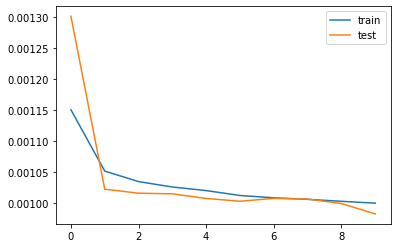

In [32]:
import matplotlib.pyplot as plt
# plot history
plt.plot(history.history['loss'][:], label='train')
plt.plot(history.history['val_loss'][:], label='test')
plt.legend()
plt.show()

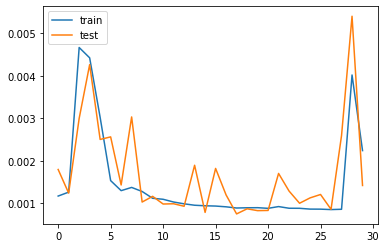

In [20]:
import matplotlib.pyplot as plt
# plot history
plt.plot(history.history['loss'][270:300], label='train')
plt.plot(history.history['val_loss'][270:300], label='test')
plt.legend()
plt.show()

# Predict

In [12]:
from tensorflow.keras.models import load_model
model = load_model('Model-LSTM2Layer-Scale.h5')

In [23]:

# x_input = np.array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x, verbose=0)
print(yhat[0])

[0.4487063]


In [24]:
yhat

array([[0.4487063 ],
       [0.45184684],
       [0.43952873],
       ...,
       [0.427674  ],
       [0.4279821 ],
       [0.42942137]], dtype=float32)

In [25]:
yhat.shape

(338635, 1)

In [26]:
y_pred = scaler_y.inverse_transform(yhat)

NameError: name 'scaler_y' is not defined

In [ ]:
y_act = np.reshape(y,(-1,1))

In [27]:
y_act = scaler_y.inverse_transform(y_act)

NameError: name 'scaler_y' is not defined

In [19]:
import matplotlib.pyplot as plt

In [20]:
y_pred_plot = np.reshape(y_pred,(y_pred.shape[0]))
y_act_plot = np.reshape(y_act,(y_act.shape[0]))

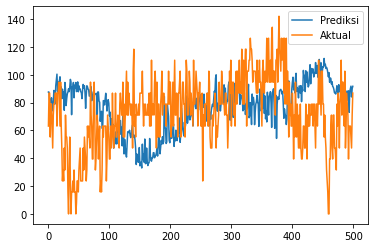

In [25]:
lmt_a = 0
lmt_b = lmt_a+500
plt.plot(y_pred_plot[lmt_a:lmt_b],label = "Prediksi")
plt.plot(y_act_plot[lmt_a:lmt_b],label = "Aktual")
plt.legend()
plt.show() 

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
mean_squared_error(y_pred_plot,y_act_plot)

172.5994315526275

In [27]:
mean_squared_error(yhat.reshape(yhat.shape[0]),y)

0.008559781367913653

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import glob
import joblib

x,y = joblib.load('x.data'),joblib.load('y.data')
n_features = 8
n_steps = 60
x = x.reshape((x.shape[0], n_steps, n_features))


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

import tensorflow as tf
tf.debugging.set_log_device_placement(True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
import time
epoch = 500
model_path = f'ModelLRBS_epoch{epoch}'
# os.mkdir(model_path)
catatan_waktu_awal = []
catatan_waktu_akhir = []
# try_BS = [10,20,50,100,150]
try_BS = [100]
try_LR = [0.1]
for batch in try_BS:
    print(batch)
    for lrate in try_LR:
        print(batch,lrate)
#         strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
#         with strategy.scope():
        
#         gpus = tf.config.list_logical_devices('GPU')
#         strategy = tf.distribute.MirroredStrategy(gpus)
        with tf.device('/device:GPU:0'):
#         with strategy.scope():
        model = Sequential()
        model.add(LSTM(100, input_shape=(60, 8), return_sequences=True))
        model.add(Flatten())
        model.add(Dense(1))
        optimizer = tf.keras.optimizers.Adam(learning_rate=lrate)
        model.compile(loss="mse", optimizer=optimizer)
        checkpoint_path = f"./{model_path}/LSTM-BS{batch}-LR{lrate}.h5"
        catatan_waktu_awal.append(time.time())
        history = model.fit(X_train, y_train,validation_data=(X_val,y_val), 
                            batch_size = batch,epochs=epoch, verbose=1)
#         model.save(f'{model_path}/LSTM-BS{batch}-LR{lrate}.h5')
        catatan_waktu_akhir.append(time.time())
#         joblib.dump(history.history,f'{model_path}/LSTM-BS{batch}-LR{lrate}.hist')

100
100 0.1
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Qr in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DiagPart in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sign in device /job:localhost/repl

270908/270908 [==============================] - 23s 86us/sample - loss: 1.9973 - val_loss: 0.1533
Epoch 12/500
 63000/270908 [=====>........................] - ETA: 16s - loss: 2.0017